In [45]:
from pybaselines import Baseline, utils
import pandas as pd
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import pickle

from scipy.optimize import nnls
from numpy.linalg import norm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


In [5]:
# open a file, where you stored the pickled data
file = open('baseline_hybrid_corrected_array.pickle', 'rb') #WIDGET - dropdown selector of files in this folder

# dump information to that file
baseline_corrected_data = pickle.load(file)

# close the file
file.close()

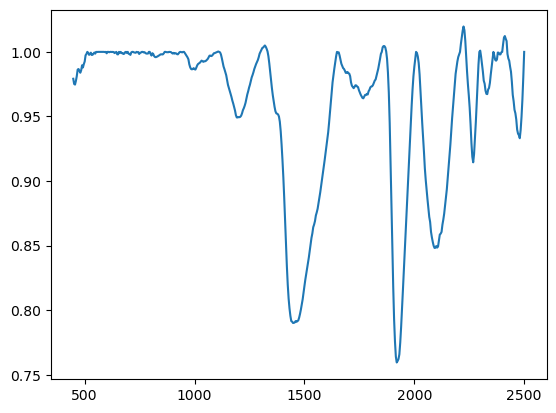

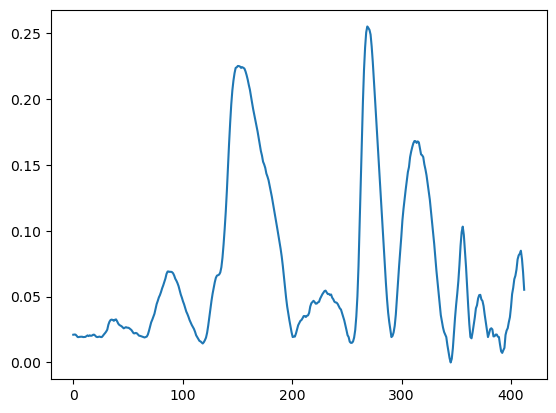

In [87]:
# Set the current spectrum in X and Y coordinates
curr_x = 25 # WIDGET - a slider bar of integers from 0 to baseline_corrected_data.shape[0]
curr_y = 50 # WIDGET - a slider bar of integers from 0 to baseline_corrected_data.shape[1]
curr_spectrum = baseline_corrected_data[curr_x,curr_y,:]

# Visualize it # WIDGET - this should replot whenever the curr_x and / or curr_y are changed
plt.plot(wav_array,
         curr_spectrum)

# Set the lower wavelength cuttoff 
curr_start = 100 # WIDGET - a slider bar from 0 to baseline_corrected_data.shape[1]
# Set the upper wavelength cutoff
curr_end = 512 # WIDGET - a slider bar from 0 to baseline_corrected_data.shape[1]
#Calculate the spectrum subset
curr_peak = curr_spectrum[curr_start:curr_end]
# Normalize the current peak so we aren't fitting above 0
# This strategy may need to be changed
curr_peak = curr_peak / curr_peak.max()
# Flip so we're looking at typical gaussians
curr_peak = 1 - curr_peak
curr_wavs = wav_array[curr_start:curr_end]
# WIDGET - this should replot whenever the curr_start and / or curr_end are changed
plt.figure()
plt.plot(np.linspace(0, curr_peak.shape[0], curr_peak.shape[0]),
          curr_peak)

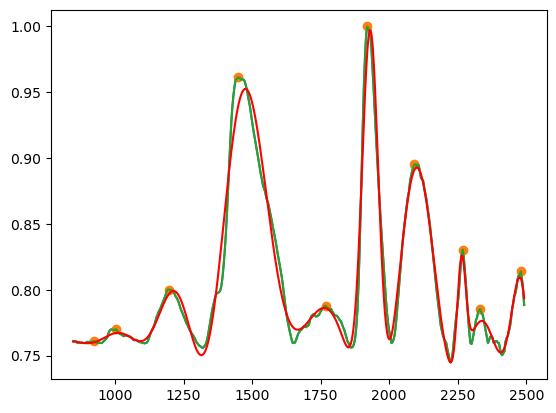

In [14]:
def func(x, *params):
    """
    Sum of Gaussians function for fitting
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

test_peaks = find_peaks(curr_peak, width=5)[0] # WIDGET controlling the width parameter - a slider bar that runs from 0 to 100
# WIDGET - this should replot whenever the width parameter changes
plt.plot(curr_wavs, curr_peak)
plt.plot(curr_wavs[test_peaks], curr_peak[test_peaks], 'o')

guess = []
for p in test_peaks:
    guess.append(np.round(curr_wavs[p]))
    guess.append(curr_peak[p])
    guess.append(10)

popt, pcov = curve_fit(func, curr_wavs, curr_peak, p0=guess)
fit = func(curr_wavs, *popt)

plt.plot(curr_wavs, curr_peak)
plt.plot(curr_wavs, fit , 'r-')
plt.show()

In [89]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import glob

# Widget to select a file from a list of pickled files in the current directory
pickle_files = glob.glob('*.pickle')
file_widget = widgets.Dropdown(options=pickle_files, description='Select file:')

# Function to open, load and close a pickled file
def load_data(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

# Widget to set the current spectrum in X and Y coordinates
x_widget = widgets.IntSlider(min=0,
                             max=100,
                             description='Current X Pixel:')
y_widget = widgets.IntSlider(min=0, max=100, description='Current Y Pixel:')

# Widget to set the lower and upper wavelength cutoff
start_widget = widgets.IntSlider(min=0, max=512, description='Start:')
end_widget = widgets.IntSlider(min=0, max=512, value = 512, description='End:')

# Widget to control the width parameter
width_widget = widgets.IntSlider(min=0, max=100, value = 5, description='Peak Width Threshold:')

def update_x_range(*args):
    baseline_corrected_data = load_data(file_widget.value)
    # x_widget.max = baseline_corrected_data.shape[0]
    # start_widget.max = baseline_corrected_data.shape[1]
    # end_widget.max = baseline_corrected_data.shape[1]
    # end_widget.value = baseline_corrected_data.shape[1]
    
file_widget.observe(update_x_range, 'value')

@interact(file=file_widget, curr_x=x_widget, curr_y=y_widget, curr_start=start_widget, curr_end=end_widget, width=width_widget)
def interactive_plot(file, curr_x, curr_y, curr_start, curr_end, width):
    baseline_corrected_data = load_data(file)

    curr_spectrum = baseline_corrected_data[curr_x,curr_y,:]
    # plt.figure()
    # plt.plot(wav_array, curr_spectrum)
    # plt.show()

    curr_peak = curr_spectrum[curr_start:curr_end]
    curr_peak = curr_peak / curr_peak.max()
    curr_peak = 1 - curr_peak
    curr_wavs = wav_array[curr_start:curr_end]

    test_peaks = find_peaks(curr_peak, width=width)[0]
    plt.plot(curr_wavs, curr_peak)
    plt.plot(curr_wavs[test_peaks], curr_peak[test_peaks], 'o')
    plt.show()

    guess = []
    for p in test_peaks:
        guess.append(np.round(curr_wavs[p]))
        guess.append(curr_peak[p])
        guess.append(10)

    try:
        popt, pcov = curve_fit(func, curr_wavs, curr_peak, p0=guess)
        fit = func(curr_wavs, *popt)

        # calculate r_squared and SSE
        residuals = curr_peak - fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((curr_peak-np.mean(curr_peak))**2)
        r_squared = 1 - (ss_res / ss_tot)
        sse = np.sum((curr_peak - fit)**2)

        plt.plot(curr_wavs, curr_peak)
        plt.plot(curr_wavs, fit , 'r-')
        # add the metrics to the plot
        plt.figtext(0.15, 0.85, 'R^2: {:.4f}'.format(r_squared))
        plt.figtext(0.15, 0.80, 'SSE: {:.4f}'.format(sse))

        # Calculate the peak dataframe
        mus = popt[np.arange(0,
                         popt.shape[0],
                         3)]
        amps = popt[np.arange(1,
                              popt.shape[0],
                              3)]
        sigmas = popt[np.arange(2,
                              popt.shape[0],
                              3)]
        
        curr_df = pd.DataFrame([mus, amps, sigmas]).T
        curr_df.columns = ['Center', 'Amplitude', 'Width']
        curr_df['FWHM'] = 2* curr_df.Width * np.sqrt(2*np.log(2))

        for _, row in curr_df.iterrows():
            plt.vlines(x=row['Center'],
                       ymin=0,
                       ymax=row['Amplitude'],
                       colors='g',
                       linestyles='dotted')
            plt.hlines(y=row['Amplitude'] / 2,
                       xmin=row['Center'] - row['FWHM']/2,
                       xmax=row['Center'] + row['FWHM']/2,
                       colors='g',
                       linestyles='dotted')
    
        plt.show()

        # Show the current fits
        print("Peaks were found in the following locations")

        display(curr_df)
        
        
    except RuntimeError:
        display("Optimization failed with the current parameters, try changing the fit parameters")




interactive(children=(Dropdown(description='Select file:', options=('baseline_corrected_array.pickle', 'baseli…

In [110]:
wav_array

array([ 448.,  452.,  456.,  460.,  464.,  468.,  472.,  476.,  480.,
        484.,  488.,  492.,  496.,  500.,  504.,  508.,  512.,  516.,
        520.,  524.,  528.,  532.,  536.,  540.,  544.,  548.,  552.,
        556.,  560.,  564.,  568.,  572.,  576.,  580.,  584.,  588.,
        592.,  596.,  600.,  604.,  608.,  612.,  616.,  620.,  624.,
        628.,  632.,  636.,  640.,  644.,  648.,  652.,  656.,  660.,
        664.,  668.,  672.,  676.,  680.,  684.,  688.,  692.,  696.,
        700.,  704.,  708.,  712.,  716.,  720.,  724.,  728.,  732.,
        736.,  740.,  744.,  748.,  752.,  756.,  760.,  764.,  768.,
        772.,  776.,  780.,  784.,  788.,  792.,  796.,  800.,  804.,
        808.,  812.,  816.,  820.,  824.,  828.,  832.,  836.,  840.,
        844.,  848.,  852.,  856.,  860.,  864.,  868.,  872.,  876.,
        880.,  884.,  888.,  892.,  896.,  900.,  904.,  908.,  912.,
        916.,  920.,  924.,  928.,  932.,  936.,  940.,  944.,  948.,
        952.,  956.,

SyntaxError: invalid syntax (4134615997.py, line 1)